In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = 12,5

Populating the interactive namespace from numpy and matplotlib


In [2]:
# This script will parse a CSV file taken from the Spectre Simulations and extract out the Early Voltage
import os
import sys
from scipy.optimize import leastsq
from pylab import *
import csv
import mpld3
from IPython.display import Image

## General functions

In [3]:
# This function reads a csv file and returns the raw data from the file,
# excluding the first line.  It will return the raw data as two lists: the first
# list will have the xVals, and the second array will have the yVals.
def readFile(filePath):
    data = genfromtxt(filePath, dtype=float, delimiter=",", skip_header=1)
    xVals = data[:,0::2]
    yVals = data[:,1::2]
    return xVals, yVals

# A function that allows the end-user to specify the type of plot he/she wants 
# to retrieve by various parameters.  Essentially, this is a wrapper on the 
# readFile function above.
def getData(folderRoot, FETType="PFET_eg1L", CurveType="IdsVgs", vdsVal="_Vds0.01"):
    fN = folderRoot + FETType + "_" + CurveType + "Curve" + vdsVal + ".csv"
    xVals, yVals = readFile(fN)
    return xVals, yVals

# fitLine takes data organized as columns of x,y pairs of data, and sorts through the columns to fit a line to each
# column's worth of data.  It returns an array for each output variable, m and b.  Each output array is of length = 
# number of columns
def fitLine(data):
    Xs, Ys = data
    ms = list()
    bs = list()
    numCols = shape(Ys)[1]
    for i in range(numCols):
        popt,pcov = leastsq(linFitErr, (0.00002, 0.00005), args=(Xs, Ys.T[i]))
        #print popt
        ms.append(popt[0])
        bs.append(popt[1])
    return array(ms), array(bs)

# getEarlyVoltages finds the slope and y-intercept of the line that best fits the data
# for x-values above "threshold"
def getEarlyVoltages(origVds, origIds, threshold):
    mask = origVds>threshold
    if len(mask)<1:
        print "WARNING: Threshold might be set too high"
    ev_Vds = origVds[mask]
    ev_Ids = origIds[mask]
    
    Ms, Bs = fitLine((ev_Vds,ev_Ids))
    EarlyVoltages = calcEV(Ms, Bs)
    print "Early Voltages:\t", EarlyVoltages
    
    return (ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs)

# calcEV takes the slope and y-intercept of a line and uses that to calculate the x-intercept.
# This allows the user to fit a linear line and calculate the Early Voltage from that.
def calcEV(m, b):
    return -b/m

# UT calculates the thermal voltage as a function of temperature (in Celsius), the value of
# electronic charge, and Boltzmann's constant.
def UT(degC):
    _k = 1.3806503e-23
    _q = 1.60217646e-19
    return(_k*(273.15+degC)/_q)

# General Subthreshold Transistor Model

(Taken from Ben's NMOS_char notebook)
\begin{align*}
I_\mathrm{D} &= C_1 e^{\kappa V_\mathrm{G}/U_\mathrm{T}}\left(1 - e^{-V_\mathrm{D}/U_\mathrm{T}} \right)\left(1 + \lambda V_\mathrm{D} \right)\\
C_1 &= e^{K_\mathrm{D}} e^{-\frac{\gamma}{U_\mathrm{T}}}
\end{align*}

In the equations above,  
    $\lambda$ = a constant correlated with the Early Voltage  
    $\gamma$ = a constant correlated with $V_{th}$  
    $\kappa$ = the normal kappa constant  
    $K_{D}$ = a constant the encapsulates all of the $I_0$ constants and correlates with $V_{th}$ as well

### Functions to be used for fitting algorithms

In [4]:
# linFit gets plots a line with slope m, and y-intercept b
def linFit(x, m, b):
    return m*x + b

# linFitErr calculates the difference between some data and a theoretical line with slope m, and
# y-intercept b.
def linFitErr(x0s, xData, yData):
    (m,b) = x0s
    return yData - linFit(xData, m, b)

# Ids_NFET models the subthreshold output drain current of an NFET transistor
# Vg is the gate voltate, Vs is the source voltage, Vd is the drain voltage
# temp is operating temperature in Celsius
def Ids_NFET(Vg, Vd, temp, kappa, gam, Kd, lamda):
    Ut = UT(temp)
    tempK = 273.15 + temp
    C1 = exp(Kd) * (-gam/Ut)
    Ids = C1 * exp(kappa*Vg/Ut) * (1 - exp(-Vd/Ut) * lamda*Vd)
    return Ids

def Ids_NFET_Err(x0s, xData, yData, Vds, temp):
    (kappa, gam, Kd, lamda) = x0s
    return yData - linFit(xData, Vds, temp, kappa, gam, Kd, lamda)

### Plotting functions

In [5]:
fntSz = 16
def plotIds(data, ttl="", xlbl="", ylbl="$I_d (A)$"):
    Xs, Ys = data
    numCols = shape(Ys)[1]
    for i in range(numCols):
        plot(Xs, Ys.T[i], '.', color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
    xlabel(xlbl, fontsize=fntSz)
    ylabel(ylbl, fontsize=fntSz)
    ylim([0,Ys.max()*1.1])
    title(ttl)

def plotlogIds(data, ttl="", xlbl="", ylbl="$I_d (A)$"):
    Xs, Ys = data
    numCols = shape(Ys)[1]
    for i in range(numCols):
        semilogy(Xs, Ys.T[i], '.', color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
    xlabel(xlbl, fontsize=fntSz)
    ylabel(ylbl, fontsize=fntSz)
    ylim([Ys.min()/10, Ys.max()*10])
    title(ttl)

def plotKappa(data, temp=25, ttl=""):
    Xs, Ys = data
    numCols = shape(Ys)[1]
    for i in range(numCols):
        dYs = diff(log(Ys.T[i]))*UT(temp)
        dXs = diff(Xs)
        plot(Xs[1:], dYs/dXs, '.', color=(1.*i/numCols, 0, 0))
    xlabel(r'$V_{gs}$', fontsize=fntSz)
    ylabel(r'$\kappa$', fontsize=fntSz)
    #ylim([Ys.min()/10, Ys.max()*10])
    title(ttl)
    
def plotEarlyVTheory(Vds, Ms, Bs, minX=-30.):
    #print "Slopes: ", Ms
    #print "Intercepts: ", Bs
    for i in range(len(Ms)):
        thIds = linFit(Vds, Ms[i], Bs[i])
        plot(Vds, thIds, "b.")
        thLineXs = arange(minX, max(Vds), 0.01)
        thIdLine = linFit(thLineXs, Ms[i], Bs[i])
        plot(thLineXs, thIdLine, "b--")
    xlims = [minX*1.05, max(Vds)]
    ylims = [0, max(thIdLine)*1.1]
    xlim(xlims)
    ylim(ylims)

## Get data from the files

In [6]:
folderRoot = "/home/noza/work/Braindrop/CDB/BDTests/NFET_test/IV_Sim_Results/ParamExtract/"

#paramFileName = folderRoot + "ParamAnalysisVals_VgSweep.csv"
#with open(paramFileName) as pfn:
#    reader = csv.reader(pfn)
#    data = list()
#    for i, row in enumerate(reader):
#        data.append(double(row[1:]))
#Vgs = data[0]
#print "Vg Vals:", Vgs
paramFileName = folderRoot + "ParamAnalysisVals_ohmicVdsTempSweep_IdVgsPlot.csv"
with open(paramFileName) as pfn:
    reader = csv.reader(pfn)
    data = list()
    for i, row in enumerate(reader):
        data.append(double(row[1:]))
print data
Vds = data[0]
print "Vd Vals:", Vds
if len(data)>1:
    temps = data[1]
    print "Temp Vals:", temps

[array([ 0.012,  0.013,  0.014]), array([  0.,  25.,  50.])]
Vd Vals: [ 0.012  0.013  0.014]
Temp Vals: [  0.  25.  50.]


## Plot the IV curves for each of the transistor types

### Plot $I_{ds}$ vs $V_{ds}$

In [ ]:
figsize(12,10)
subplot(2,2,1)
plotIds((origVds_1L, origIds_1L_Vds*1e6),
        ttl="Thin-FET, 1L, Varying $V_{gs}$", xlbl=r'$V_{ds}$', ylbl=r'$I_d (\mu A)$')
subplot(2,2,2)
plotIds((origVds_3L, origIds_3L_Vds*1e6),
        ttl="Thin-FET, 3L, Varying $V_{gs}$", xlbl=r'$V_{ds}$', ylbl=r'$I_d (\mu A)$')
subplot(2,2,3)
plotIds((origVds_eg1L, origIds_eg1L_Vds*1e6),
        ttl="Thick-FET, 1L, Varying $V_{gs}$", xlbl=r'$V_{ds}$', ylbl=r'$I_d (\mu A)$')
subplot(2,2,4)
plotIds((origVds_eg3L, origIds_eg3L_Vds*1e6),
        ttl="Thick-FET, 3L, Varying $V_{gs}$", xlbl=r'$V_{ds}$', ylbl=r'$I_d (\mu A)$')
tight_layout()
show()

### Plot $I_{ds}$, $g_m$, and $\frac{g_m}{I_{ds}}$ vs $V_{gs}$
From the transconductance-to-current plot, we'll be able to extract $I_S$ and $V_T$

In [229]:
def plotVgPlots(origVgs, origVgsIds, ttl):
    gms = diff(origVgsIds, axis=0)/diff(origVgs, axis=0)
    gmOverId = gms/origVgsIds[:-1]
    
    # Calculate the threshold voltage from the last plot's data
    half_gmToIdRatio = gmOverId.max(axis=0)*0.53  #from S&GM, p.462, footnote 1
    numCols = len(half_gmToIdRatio)
    #print "Half of max(gm/Id ratio):", half_gmToIdRatio
    Vth = list()
    for i, curHalfPt in enumerate(half_gmToIdRatio):
        Vth.append(origVgs[where(gmOverId>curHalfPt)][-1])
    #print "Vth (over temperature): ", Vth
    
    ISVals = list()
    for i, curVth in enumerate(Vth):
        Vth_idx = where(origVgs[:,i]==Vth[i])
        ISVals.append(origVgsIds[Vth_idx, i])
    print "IS Vals: ", array(ISVals).flatten()
  
    subplot(1,3,1)
    plotlogIds((origVgs, origVgsIds), ttl=ttl, xlbl=r'$V_{gs}$')
    for i, curHalfPt in enumerate(half_gmToIdRatio):
        # Use the threshold voltage calculated to plot a vertical line in the plot
        vlines(Vth[i], origVgsIds.min()/10, origVgsIds.max()*10,
               colors=(1.*i/(numCols-1), 0, 1-(1.*i/(numCols-1))),
               linestyles='dashed')
    
    subplot(1,3,2)
    plotlogIds((origVgs[:-1], gms), 
               ttl=ttl, xlbl=r'$V_{gs}$', ylbl=r'$g_m$')
    
    subplot(1,3,3)
    plotIds((origVgs[:-1], gmOverId), 
               ttl=ttl, xlbl=r'$V_{gs}$', ylbl=r'$g_m/I_{ds}$')
    for i, curHalfPt in enumerate(half_gmToIdRatio):
        # Use the threshold voltage calculated to plot a vertical line in the plot
        hlines(curHalfPt, 0, 1,
               colors=(1.*i/(numCols-1), 0, 1-(1.*i/(numCols-1))),
               linestyles='dashed')
        vlines(Vth[i], gmOverId.min()/10, gmOverId.max()*10,
               colors=(1.*i/(numCols-1), 0, 1-(1.*i/(numCols-1))),
               linestyles='dashed')

    tight_layout()

    return Vth, ISVals

IS Vals:  [  2.46891610e-07   3.48840007e-07   4.57369723e-07]
Vth_1L:  [0.49504950495049532, 0.50495049504950518, 0.51485148514851509]
IS_1L:  [array([[  2.46891610e-07]]), array([[  3.48840007e-07]]), array([[  4.57369723e-07]])]
IS Vals:  [  8.96205072e-08   1.38908969e-07   1.88405147e-07]
Vth_eg1L:  [0.64356435643564391, 0.65346534653465382, 0.66336633663366373]
IS_eg1L:  [array([[  8.96205072e-08]]), array([[  1.38908969e-07]]), array([[  1.88405147e-07]])]


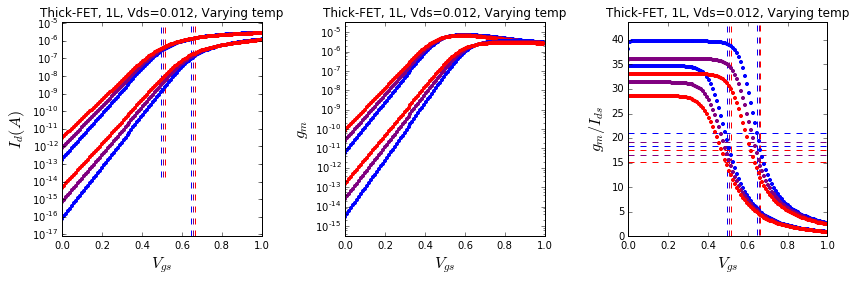

IS Vals:  [  2.64907152e-07   3.74985061e-07   5.53036914e-07]
Vth_1L:  [0.49504950495049532, 0.50495049504950518, 0.524752475247525]
IS_1L:  [array([[  2.64907152e-07]]), array([[  3.74985061e-07]]), array([[  5.53036914e-07]])]
IS Vals:  [  9.60397670e-08   1.49246244e-07   2.02794731e-07]
Vth_eg1L:  [0.64356435643564391, 0.65346534653465382, 0.66336633663366373]
IS_eg1L:  [array([[  9.60397670e-08]]), array([[  1.49246244e-07]]), array([[  2.02794731e-07]])]


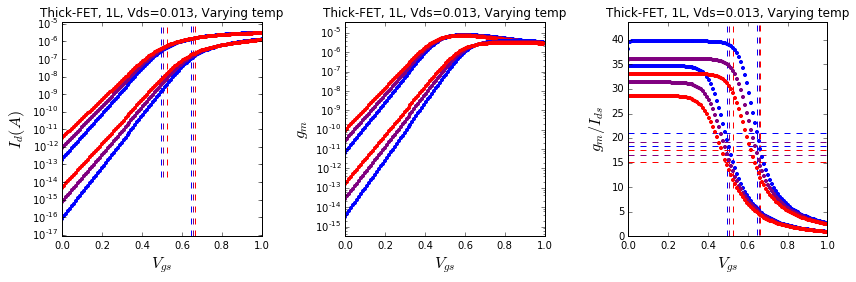

IS Vals:  [  2.82548794e-07   4.62507145e-07   5.92053696e-07]
Vth_1L:  [0.49504950495049532, 0.51485148514851509, 0.524752475247525]
IS_1L:  [array([[  2.82548794e-07]]), array([[  4.62507145e-07]]), array([[  5.92053696e-07]])]
IS Vals:  [  1.02307190e-07   1.59399470e-07   2.16986620e-07]
Vth_eg1L:  [0.64356435643564391, 0.65346534653465382, 0.66336633663366373]
IS_eg1L:  [array([[  1.02307190e-07]]), array([[  1.59399470e-07]]), array([[  2.16986620e-07]])]


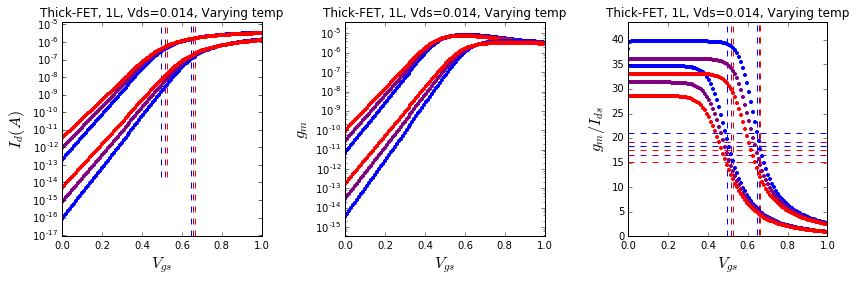

In [230]:
figsize(12,4)
#print Vds
#print temps
for i, Vd in enumerate(Vds):
    #print Vd
    origVgs_1L, origVgsIds_1L = getData(folderRoot, FETType="PFET_1L",
                                        CurveType="IdsVgs", vdsVal="_Vds"+str(Vd))
    Vth_1L, IS_1L = plotVgPlots(origVgs_1L, origVgsIds_1L, 
                                ttl="Thin-FET, 1L, Vds="+str(Vd)+", Varying temp")
    print "Vth_1L: ", Vth_1L
    print "IS_1L: ", IS_1L
    
    origVgs_eg1L, origVgsIds_eg1L = getData(folderRoot, FETType="PFET_eg1L",
                                            CurveType="IdsVgs", vdsVal="_Vds"+str(Vd))
    Vth_eg1L, IS_eg1L = plotVgPlots(origVgs_eg1L, origVgsIds_eg1L,
                                    ttl="Thick-FET, 1L, Vds="+str(Vd)+", Varying temp")
    print "Vth_eg1L: ", Vth_eg1L
    print "IS_eg1L: ", IS_eg1L
    show()

### Plot $\kappa$

In [ ]:
figsize(12,10)
subplot(2,2,1)
plotKappa((origVgs_1L, origIds_1L_Vgs), ttl="Thin-FET, 1L, Varying $V_{ds}$")
subplot(2,2,2)
plotKappa((origVgs_3L, origIds_3L_Vgs), ttl="Thin-FET, 3L, Varying $V_{ds}$")
subplot(2,2,3)
plotKappa((origVgs_eg1L, origIds_eg1L_Vgs), ttl="Thick-FET, 1L, Varying $V_{ds}$")
subplot(2,2,4)
plotKappa((origVgs_eg3L, origIds_eg3L_Vgs), ttl="Thick-FET, 3L, Varying $V_{ds}$")
tight_layout()
show()

### Find and Plot the Early Voltages

In [ ]:
threshold = 0.6

figsize(12,10)
subplot(2,2,1)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_1L, origIds_1L_Vds, threshold)
plotIds((origVds_1L, origIds_1L_Vds), ttl="Thin-FET, 1L, Varying $V_{gs}$", xlbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -4)

subplot(2,2,2)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_3L, origIds_3L_Vds, threshold)
plotIds((origVds_3L, origIds_3L_Vds), ttl="Thin-FET, 3L, Varying $V_{gs}$", xlbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -6)

subplot(2,2,3)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_eg1L, origIds_eg1L_Vds, threshold)
plotIds((origVds_eg1L, origIds_eg1L_Vds), ttl="Thick-FET, 1L, Varying $V_{gs}$", xlbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -10)

subplot(2,2,4)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_eg3L, origIds_eg3L_Vds, threshold)
plotIds((origVds_eg3L, origIds_eg3L_Vds), ttl="Thick-FET, 3L, Varying $V_{gs}$", xlbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -16)

tight_layout()
show()

# Appendix

## Fit the subthreshold region for parameters

In [ ]:
temp = 25
print Vds
print xData
print yData

popt, pcov = leastsq(Ids_NFET_Err, (0.7, 0.6, -9, 0.05), args=(xData, yData, Vds, temp))
kappa = popt[0]
gam = popt[1]
Kd = popt[2]
lamda = popt[3]